In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# Specify paths
parcel_file_csv = "Data/Parcel_chars_Beaufort.csv"  # Specify parcel characteristics file used when running the model
parcel_file_shp = "Data/Beaufort_final_8.shp"
results_path = "Results/"  # Change this for different output files

### Buyers, sellers, transactions


In [3]:
df_list = []

i = 0
for file in os.listdir(results_path):
    if file.startswith("model") and file.endswith("pkl"):
        model_df = pd.read_pickle(results_path + file)
        model_df["Step"] = model_df.index
        model_df["Run"] = int(file.split("]")[0][-1])
        df_list.append(model_df)
        i += 1

model_df = pd.concat(df_list)
model_df["Year"] = 0.5 * model_df["Step"]
model_df

,Households,N_sellers,N_buyers,Sold properties,Successful sellers,Successful buyers,P_ask,P_bid,P_trans,Trans history,Regression coefs,Step,Run,Year
0,3520,0,0,[],[],[],[],[],[],0,"[1.8780119163273632, 0.008169998942764739, 1.3...",0,0,0.0
1,3765,369,245,"[6217.0, 4573.0, 3208.0, 3589.0, 4395.0, 4767....","[19, 39, 125, 244, 296, 365, 384, 416, 425, 44...","[3809, 3565, 3728, 3797, 3559, 3748, 3613, 368...","[436100.0, 95800.0, 227900.0, 150700.0, 122900...","[441000, 96000, 234000, 153000, 126000, 433000...","[441000, 96000, 234000, 153000, 126000, 433000...",0,"[1.8780119163273632, 0.008169998942764739, 1.3...",1,0,0.5
2,3951,707,431,"[5103.0, 3160.0, 1706.0, 2924.0, 6320.0, 6325....","[33, 49, 79, 88, 101, 102, 110, 119, 137, 148,...","[3805, 3950, 3951, 3775, 3833, 3930, 3714, 407...","[661000.0, 194500.0, 151700.0, 220000.0, 37320...","[681000, 202000, 158000, 226000, 377000, 27300...","[681000, 202000, 158000, 226000, 377000, 27300...",1,"[1.8780119163273632, 0.008169998942764739, 1.3...",2,0,1.0
3,4125,959,605,"[5696.0, 2624.0, 1274.0, 4683.0, 6356.0, 2139....","[23, 47, 66, 68, 92, 93, 132, 144, 152, 158, 1...","[4136, 3976, 3564, 4183, 4045, 3683, 3945, 375...","[78210.0, 65800.0, 61800.0, 223400.0, 402732.0...","[77000, 66000, 60000, 226000, 385000, 272000, ...","[78210.0, 66000, 61800.0, 226000, 385000, 2720...",2,"[1.8780119163273632, 0.008169998942764739, 1.3...",3,0,1.5
4,4199,902,679,"[6302.0, 1668.0, 4968.0, 2729.0, 3427.0, 6096....","[5, 24, 27, 29, 34, 38, 57, 67, 75, 109, 116, ...","[4445, 4662, 3977, 4693, 3626, 3693, 4315, 467...","[223400.0, 133300.0, 184600.0, 94500.0, 74800....","[234000, 132000, 186000, 94000, 75000, 269000,...","[234000, 132000, 186000, 94500.0, 75000, 26900...",3,"[1.8780119163273632, 0.008169998942764739, 1.3...",4,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,4265,712,745,"[688.0, 3316.0, 5424.0, 2926.0, 5457.0, 2565.0...","[30, 948, 1069, 1316, 1557, 2007, 2157, 2337, ...","[19060, 20600, 20318, 20380, 20062, 17840, 204...","[121600.0, 139491.0, 261954.0, 215300.0, 60700...","[122000, 138000, 259000, 223000, 63000, 63000,...","[122000, 138000, 259000, 223000, 63000, 63000,...",55,"[1.8780119163273632, 0.008169998942764739, 1.3...",56,6,28.0
57,4228,697,708,"[3533.0, 3456.0, 6533.0, 5811.0, 2787.0, 4887....","[223, 595, 1144, 1196, 1207, 1430, 1602, 1891,...","[20987, 20098, 20558, 19323, 20083, 11750, 203...","[206415.0, 81800.0, 86130.0, 172200.0, 243600....","[211000, 85000, 90000, 167000, 253000, 75000, ...","[211000, 85000, 90000, 167000, 253000, 75000, ...",56,"[1.8780119163273632, 0.008169998942764739, 1.3...",57,6,28.5
58,4261,734,741,"[5276.0, 2939.0, 5110.0, 2763.0, 1578.0, 4491....","[96, 341, 762, 974, 988, 1460, 1477, 1611, 190...","[21177, 21315, 21226, 21126, 20287, 21318, 214...","[60700.0, 187902.0, 148500.0, 220176.0, 62469....","[64000, 184000, 143000, 215000, 61000, 68000, ...","[64000, 184000, 143000, 215000, 61000, 68000, ...",57,"[1.8780119163273632, 0.008169998942764739, 1.3...",58,6,29.0
59,4232,805,712,"[2086.0, 284.0, 1939.0, 5012.0, 4625.0, 2083.0...","[189, 628, 1040, 1245, 1354, 1539, 1579, 1631,...","[21487, 21218, 21754, 19492, 15028, 21009, 210...","[61500.0, 61800.0, 62700.0, 60500.0, 66300.0, ...","[64000, 63000, 64000, 62000, 69000, 61000, 237...","[64000, 63000, 64000, 62000, 69000, 61200.0, 2...",58,"[1.8780119163273632, 0.008169998942764739, 1.3...",59,6,29.5


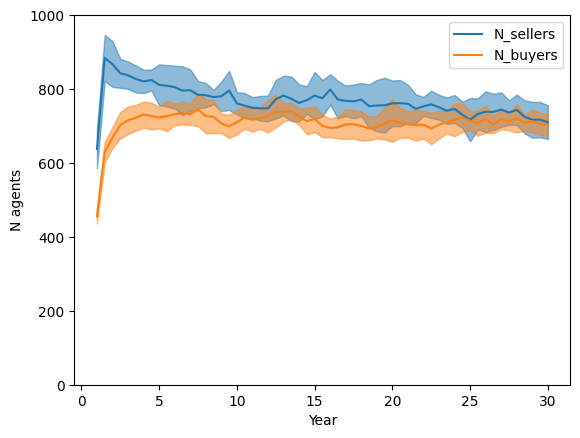

In [4]:
%matplotlib inline
model_df_mean = model_df.groupby(["Year"])[["N_sellers", "N_buyers"]].mean()
model_df_std = model_df.groupby(["Year"])[["N_sellers", "N_buyers"]].std()

model_df_mean = model_df_mean[1:]
model_df_std = model_df_std[1:]

model_df_mean.plot()
for i, group in enumerate(["N_sellers", "N_buyers"]):
    plt.fill_between(model_df_mean.index,
                     (model_df_mean - model_df_std)[group],
                     (model_df_mean + model_df_std)[group],
                     color=plt.legend().legendHandles[i].get_color(),
                     alpha=0.5)

plt.ylabel("N agents")
plt.ylim(0, 1000)
plt.show()

### Prices, incomes, transactions per flood zone

In [5]:
# Read spatial data
spatial_df = gpd.read_file(parcel_file_shp)
spatial_df = spatial_df.rename(columns={"ID1": "Property ID"}).set_index("Property ID")

# Redo original preprocessing for relevant parcel attributes
spatial_df.loc[spatial_df["DFLOOD_A_1"] == 1, "FLOOD_PROB"] = 0.01
spatial_df.loc[spatial_df["DFLOOD_X_1"] == 1, "FLOOD_PROB"] = 0.002
spatial_df["FLOOD_PROB"] = spatial_df["FLOOD_PROB"].drop(columns=["DFLOOD_A_1", "DFLOOD_X_1"])
spatial_df["FLOOD_PROB"] = spatial_df["FLOOD_PROB"].fillna(0)

# Disregard roads for visualization
spatial_df = spatial_df.drop([2, 4, 153, 923, 966, 1042, 1283, 1290, 1492, 1710, 1808, 2241, 2313,
                              2375, 2671, 2902, 3015, 3078, 3107, 3131, 3134, 3709, 3870, 4257, 4281, 5507])
# spatial_df.head()

In [6]:
buyers_df_list = []
owners_df_list = []
i = 0
for file in os.listdir(results_path):
    if file.startswith("agent") and file.endswith("pkl"):
        agent_df = pd.read_pickle(results_path + file)
        buyers_df = agent_df[(agent_df["Type"] == "Household") & (agent_df['Property ID'].isna())].copy()
        buyers_df["Run"] = int(file.split("]")[0][-1])
        buyers_df_list.append(buyers_df)
        owners_df = agent_df[(agent_df["Type"] == "Household") & (~agent_df['Property ID'].isna())].copy()
        owners_df["Run"] = int(file.split("]")[0][-1])
        owners_df_list.append(owners_df)
        i += 1

owners_df = pd.concat(owners_df_list)
owners_df = owners_df.reset_index().set_index("Property ID")
owners_df["FLOOD_PROB"] = spatial_df["FLOOD_PROB"]
owners_df["Year"] = 0.5 * owners_df["Step"]
owners_df["geometry"] = spatial_df["geometry"]
owners_df = gpd.GeoDataFrame(owners_df)
owners_df = owners_df.reset_index().set_index(["Year", "Run", "FLOOD_PROB"])

buyers_df = pd.concat(buyers_df_list).reset_index()
buyers_df["Year"] = 0.5 * buyers_df["Step"]
buyers_df = buyers_df.set_index(["Year", "Run"])

owners_df

Property ID  Step  AgentID       Type Market status  \
Year Run FLOOD_PROB                                                        
0.0  6   0.000            6121.0     0        1  Household      Inactive   
         0.002            5303.0     0        2  Household      Inactive   
         0.000            3072.0     0        3  Household      Inactive   
         0.010             858.0     0        4  Household      Inactive   
         0.010            3565.0     0        5  Household      Inactive   
...                          ...   ...      ...        ...           ...   
30.0 9   0.000            4020.0    60    22167  Household      Inactive   
         0.000            1947.0    60    22169  Household      Inactive   
         0.000            3419.0    60    22172  Household      Inactive   
         0.010            3630.0    60    22176  Household      Inactive   
         0.000            2055.0    60    22178  Household      Inactive   

                       Income  Property price  Property N sales  Coastal pref  \
Year Run FLOOD_PROB                                                             
0.0  6   0.000        35760.0        227100.0               0.0      0.493102   
         0.002        23780.0        119100.0               0.0      0.574856   
         0.000       119000.0        175600.0               0.0      0.457669   
         0.010         8362.0         12200.0               0.0      0.564619   
         0.010        42000.0        204900.0               0.0      0.454708   
...                       ...             ...               ...           ...   
30.0 9   0.000         8860.0         74000.0               6.0      0.367634   
         0.000        28170.0        208000.0               1.0      0.499038   
         0.000        12030.0        104000.0               8.0      0.405193   
         0.010        25030.0        221000.0               9.0      0.503110   
         0.000        14310.0        105000.0               1.0      0.529967   

                     RP bias  \
Year Run FLOOD_PROB            
0.0  6   0.000           0.0   
         0.002           0.0   
         0.000           0.0   
         0.010           0.0   
         0.010           0.0   
...                      ...   
30.0 9   0.000           0.0   
         0.000           0.0   
         0.000           0.0   
         0.010           0.0   
         0.000           0.0   

                                                              geometry  
Year Run FLOOD_PROB                                                     
0.0  6   0.000       POLYGON ((2709002.868 358754.322, 2708985.473 ...  
         0.002       POLYGON ((2707187.180 360133.926, 2707186.183 ...  
         0.000       POLYGON ((2703834.027 369540.555, 2703722.526 ...  
         0.010       POLYGON ((2711145.994 390927.456, 2710875.927 ...  
         0.010       POLYGON ((2713291.496 365470.991, 2713389.999 ...  
...                                                                ...  
30.0 9   0.000       POLYGON ((2706296.882 363344.295, 2706200.631 ...  
         0.000       POLYGON ((2713875.643 378256.762, 2713843.642 ...  
         0.000       POLYGON ((2705878.595 366444.981, 2705693.842 ...  
         0.010       POLYGON ((2713371.503 364963.455, 2713245.252 ...  
         0.000       POLYGON ((2703092.450 377802.449, 2702940.698 ...  

[2147200 rows x 11 columns]

#### Household incomes

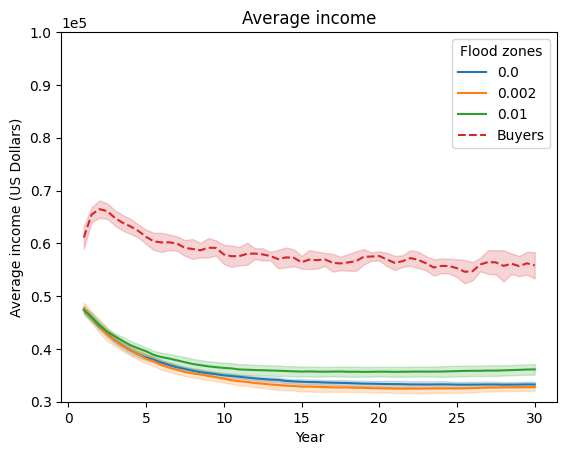

In [7]:
# Buyers income
buyers_mean = buyers_df[["Income"]].groupby(["Year", "Run"]).mean().groupby("Year").mean()
buyers_std = buyers_df[["Income"]].groupby(["Year", "Run"]).mean().groupby("Year").std()

# Owners income per flood zone
owners_mean = owners_df[["Income"]].groupby(["Year", "Run", "FLOOD_PROB"]).mean()["Income"].groupby(["Year", "FLOOD_PROB"]).mean().unstack()
owners_std = owners_df[["Income"]].groupby(["Year", "Run", "FLOOD_PROB"]).mean()["Income"].groupby(["Year", "FLOOD_PROB"]).std().unstack()

# Do not plot first timestep
owners_mean = owners_mean.loc[1:]
owners_std = owners_std.loc[1:]
buyers_mean = buyers_mean[1:]
buyers_std = buyers_std[1:]

# Plot average incomes + std
fig, ax = plt.subplots()
owners_mean.plot(ax=ax)
for i, prob in enumerate([0, 0.002, 0.01]):
    ax.fill_between(owners_mean.index,
                    owners_mean[prob] - owners_std[prob],
                    owners_mean[prob] + owners_std[prob],
                    alpha=0.2, color=plt.legend().legendHandles[i].get_color())

ax.plot(buyers_mean, label="Buyers", color="tab:red", ls="--")
ax.fill_between(buyers_mean.index,
                (buyers_mean - buyers_std).values.flatten(),
                (buyers_mean + buyers_std).values.flatten(),
                alpha=0.2, color="tab:red")

plt.ticklabel_format(axis='y', scilimits=(0, 0))
plt.ylim(3e4, 1e5)
plt.ylabel("Average income (US Dollars)")
plt.title("Average income")
plt.legend(title="Flood zones")
plt.show()

#### Property prices

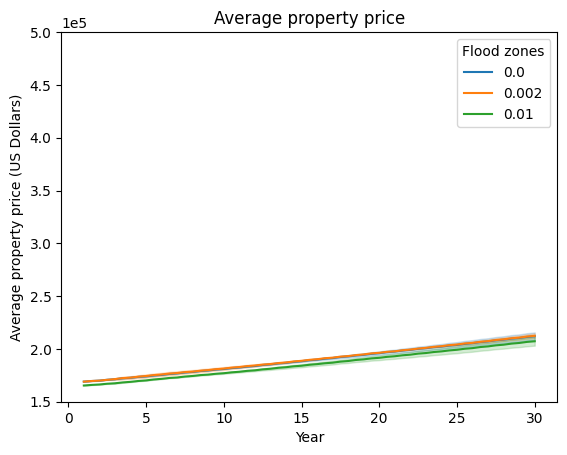

In [8]:
%matplotlib inline
# Average property prices
owners_mean = owners_df[["Property price"]].groupby(["Year", "Run", "FLOOD_PROB"]).mean()["Property price"].groupby(["Year", "FLOOD_PROB"]).mean().unstack()
owners_std = owners_df[["Property price"]].groupby(["Year", "Run", "FLOOD_PROB"]).mean()["Property price"].groupby(["Year", "FLOOD_PROB"]).std().unstack()

owners_mean = owners_mean[1:]
owners_std = owners_std[1:]

fig, ax = plt.subplots()
owners_mean.plot(ax=ax)
for i, prob in enumerate([0, 0.002, 0.01]):
    ax.fill_between(owners_mean.index,
                    owners_mean[prob] - owners_std[prob],
                    owners_mean[prob] + owners_std[prob],
                    alpha=0.2, color=plt.legend().legendHandles[i].get_color())

plt.ticklabel_format(axis='y', scilimits=(0, 0))
plt.ylim(1.5e5, 5e5)
plt.ylabel("Average property price (US Dollars)")
plt.title("Average property price")
plt.legend(title="Flood zones")
plt.show()

#### Income/price ratio (compare runs)

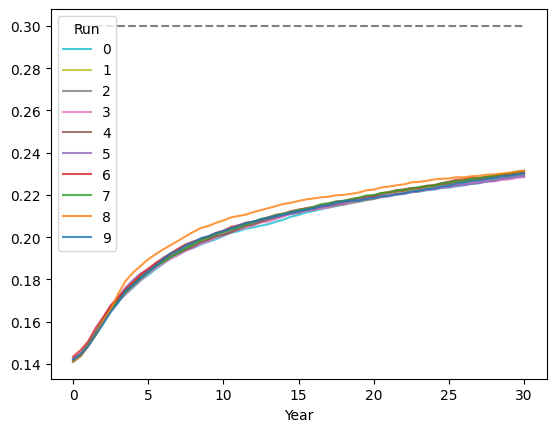

In [9]:
# Get ratio of property price / income / 30 (years mortgage).
# The resulting number is related to the maximum 30% of income spent on housing
# rule as described in Filatova (2015). The grey line indicated this maximum value.
ratio_df = owners_df[["Income", "Property price"]].copy()
ratio_df["Income price ratio"] = ratio_df["Property price"]/ratio_df["Income"]/30
ratio_df = ratio_df.groupby(["Year", "Run"]).mean()["Income price ratio"].unstack()
ratio_df.plot(cmap="tab10_r", alpha=0.8)
plt.hlines(0.3, min(ratio_df.index), max(ratio_df.index),
           color="grey", linestyle="--")
plt.show()

#### Income/price ratio (average over runs, per flood zone)

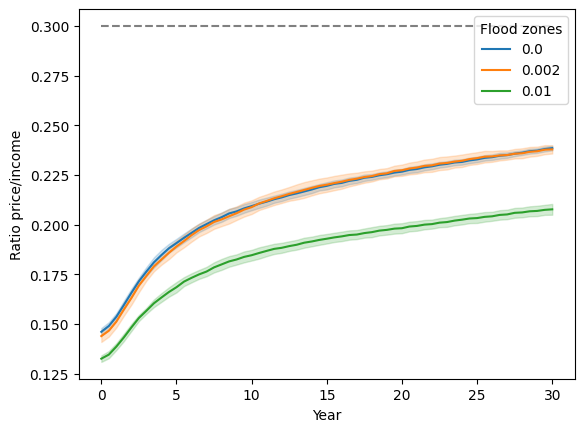

In [10]:
# Owners income per flood zone
owners_df["Income price ratio"] = owners_df["Property price"]/owners_df["Income"]/30
owners_mean = owners_df[["Income price ratio"]].groupby(["Year", "Run", "FLOOD_PROB"]).mean()["Income price ratio"].groupby(["Year", "FLOOD_PROB"]).mean().unstack()
owners_std = owners_df[["Income price ratio"]].groupby(["Year", "Run", "FLOOD_PROB"]).mean()["Income price ratio"].groupby(["Year", "FLOOD_PROB"]).std().unstack()

# Plot average incomes + std
fig, ax = plt.subplots()
owners_mean.plot(ax=ax)
for i, prob in enumerate([0, 0.002, 0.01]):
    ax.fill_between(owners_mean.index,
                    owners_mean[prob] - owners_std[prob],
                    owners_mean[prob] + owners_std[prob],
                    alpha=0.2, color=plt.legend().legendHandles[i].get_color())

plt.hlines(0.3, min(ratio_df.index), max(ratio_df.index),
           color="grey", linestyle="--")
plt.ylabel("Ratio price/income")
plt.legend(title="Flood zones")
plt.show()

#### Transactions per flood zone

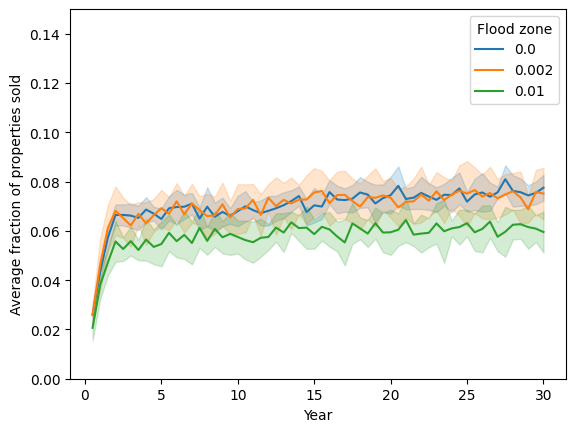

In [11]:
# Load transactions and order per run per property
trans_per_flood_df = model_df[["Sold properties", "P_ask", "P_bid", "P_trans", "Run"]].copy()
trans_per_flood_df = trans_per_flood_df.drop(0)
trans_per_flood_df.index.rename("Year", inplace=True)
trans_per_flood_df.index = trans_per_flood_df.index * 0.5
trans_per_flood_df = trans_per_flood_df.set_index("Run", append=True)
trans_per_flood_df = trans_per_flood_df.explode(["Sold properties", "P_ask", "P_bid", "P_trans"])
trans_per_flood_df = trans_per_flood_df.reset_index().set_index(["Run", "Sold properties"])

trans_per_flood_df = pd.get_dummies(trans_per_flood_df["Year"])
trans_per_flood_df = trans_per_flood_df.groupby(["Run", "Sold properties"]).sum()
trans_per_flood_df = trans_per_flood_df.reset_index().set_index(["Sold properties"])
trans_per_flood_df = trans_per_flood_df.merge(spatial_df[["FLOOD_PROB"]], left_index=True, right_index=True)
trans_per_flood_df = trans_per_flood_df.groupby(["FLOOD_PROB", "Run"]).sum()
trans_per_flood_df = trans_per_flood_df.transpose()
trans_per_flood_df[0.01] = trans_per_flood_df[0.01]/944
trans_per_flood_df[0.002] = trans_per_flood_df[0.002]/832
trans_per_flood_df[0] = trans_per_flood_df[0]/1745

# Get mean and std over runs
trans_per_flood_df_mean = trans_per_flood_df.transpose().groupby("FLOOD_PROB").mean()
trans_per_flood_df_std = trans_per_flood_df.transpose().groupby("FLOOD_PROB").std()
trans_per_flood_df_std

trans_per_flood_df_mean.transpose().plot()
for i, prob in enumerate([0,  0.002, 0.01]):
    plt.fill_between(list(trans_per_flood_df_mean.columns.values),
                     trans_per_flood_df_mean.loc[prob] - trans_per_flood_df_std.loc[prob],
                     trans_per_flood_df_mean.loc[prob] + trans_per_flood_df_std.loc[prob],
                     alpha=0.2, color=plt.legend().legendHandles[i].get_color())

plt.ylim(0, 0.15)
plt.xlabel("Year")
plt.ylabel("Average fraction of properties sold")
plt.legend(title="Flood zone")
plt.show()

## Price estimation: fitting regression or kriging model

#### Regression coefficients

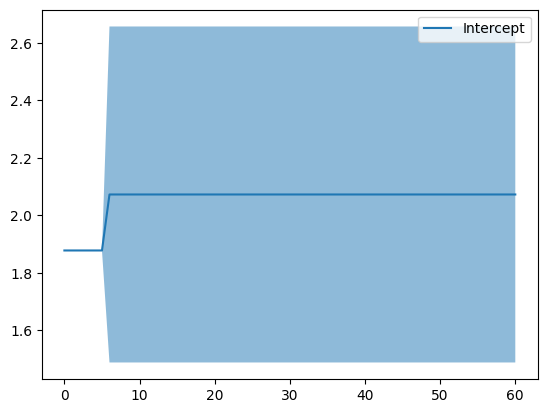

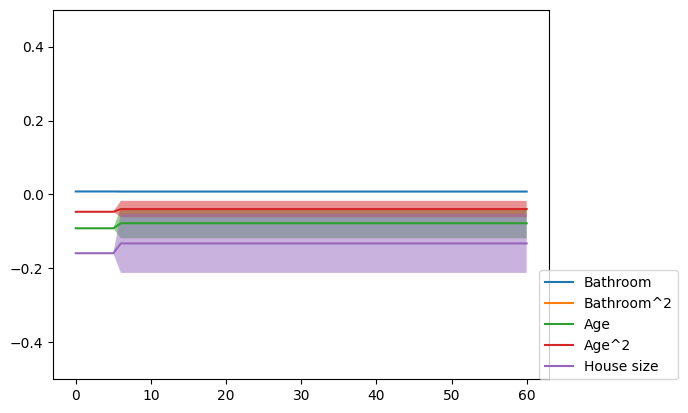

In [12]:
%matplotlib inline
coefs_avg = model_df["Regression coefs"].groupby(model_df["Step"]).mean()
coefs_std = model_df[["Regression coefs"]].stack().groupby(level=0).apply(lambda x:
                                                                          np.round(np.array(x).std(), 4))

coefs_avg = pd.DataFrame(coefs_avg.values.tolist())
coefs_std = pd.DataFrame(coefs_std.values.tolist())

coefs_avg[0].plot(label="Intercept")
plt.fill_between(coefs_avg.index,
                 coefs_avg[0] - coefs_std[0],
                 coefs_avg[0] + coefs_std[0],
                 alpha=0.5)
# plt.ylim(10, 14)
plt.legend()
plt.show()

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
if "Results/Kriging" in results_path:
    labels = ["Age", "House size", "Lot size", "N bedrooms", "Flood zone"]
else:
    labels = ["Bathroom", "Bathroom^2",
              "Age", "Age^2",
              "House size", "House size^2",
              "Lot size", "Lot size^2",
              "New home", "Post firm", "100 flood zone", "500 flood zone", "Coastal front",
              "Distance amen", "Distance CBD", "Distance highway", "Distance park"
             ]
coefs_avg = coefs_avg.drop(columns=0)
coefs_std = coefs_std.drop(columns=0)
for coef in coefs_avg.columns:
    plt.plot(coefs_avg[coef], label=labels[coef-1])
for coef in coefs_avg.columns:
    plt.fill_between(coefs_avg.index,
                     coefs_avg[coef] - coefs_std[coef],
                     coefs_avg[coef] + coefs_std[coef],
                     alpha=0.5)
plt.ylim(-0.5, 0.5)
plt.legend(loc=(0.98, 0))
plt.show()

#### Number of historical transactions needed to fit model


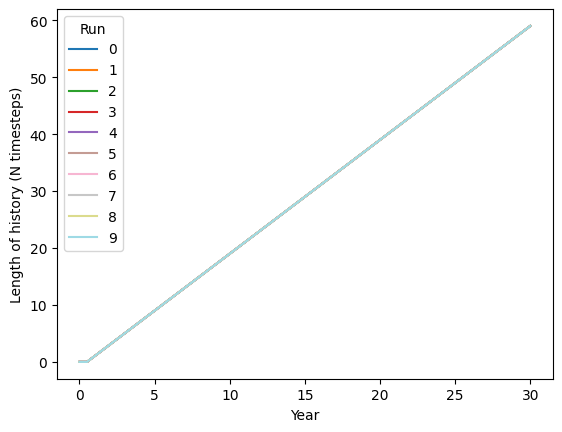

In [13]:
%matplotlib inline

trans_history = model_df.groupby(["Year", "Run"])["Trans history"].mean().unstack()
trans_history.plot(cmap="tab20")
plt.ylabel("Length of history (N timesteps)")
plt.show()

## Spatial plots


#### Variables per agent/property

In [69]:
property_df_list = []
i = 0
for file in os.listdir(results_path):
    if file.startswith("agent") and file.endswith("pkl"):
        agent_df = pd.read_pickle(results_path + file)
        property_df = agent_df[(agent_df["Type"] == "Household") & (~agent_df['Property ID'].isna())].copy()
        property_df["Run"] = int(file.split("]")[0][-1])
        property_df_list.append(property_df)
        i += 1

# Add flood zones
property_df = pd.concat(property_df_list)
property_df = property_df.reset_index().set_index("Property ID")
property_df["FLOOD_PROB"] = spatial_df["FLOOD_PROB"]
property_df["Year"] = 0.5 * property_df["Step"]
property_df["geometry"] = spatial_df["geometry"]
property_df = gpd.GeoDataFrame(property_df)
property_df = property_df.reset_index().set_index(["Run", "Step", "Property ID"])
# property_df

In [70]:
# Add price changes per property
price_gradients = property_df.sort_values(["Run", "Property ID"])["Property price"].diff()
property_df["Price change"] = price_gradients
property_df = property_df.reset_index().set_index("Property ID")
property_df.loc[property_df["Step"] == 0, ["Price change"]] = 0
# property_df

In [71]:
# Add cumulative price changes
property_df = property_df.sort_values(["Run", "Property ID"])
prices = property_df.groupby(["Run", "Property ID"])["Price change"]
property_df["Cumulative price change"] = prices.cumsum()
property_df = property_df.reset_index().set_index("Property ID")
property_df

,Run,Step,AgentID,Type,Market status,Income,Property price,Property N sales,Coastal pref,RP bias,FLOOD_PROB,Year,geometry,Price change,Cumulative price change
Property ID,,,,,,,,,,,,,,,
103.0,0,0,763,Household,Inactive,21980.0,127700.0,0.0,0.522350,0.0,0.01,0.0,"POLYGON ((2709369.134 401503.229, 2709325.885 ...",0.0,0.0
103.0,0,1,763,Household,Inactive,21980.0,127700.0,0.0,0.522350,0.0,0.01,0.5,"POLYGON ((2709369.134 401503.229, 2709325.885 ...",0.0,0.0
103.0,0,2,763,Household,Seller,21980.0,127700.0,0.0,0.522350,0.0,0.01,1.0,"POLYGON ((2709369.134 401503.229, 2709325.885 ...",0.0,0.0
103.0,0,3,763,Household,Seller,21980.0,126500.0,0.0,0.522350,0.0,0.01,1.5,"POLYGON ((2709369.134 401503.229, 2709325.885 ...",-1200.0,-1200.0
103.0,0,4,763,Household,Seller,21980.0,125235.0,0.0,0.522350,0.0,0.01,2.0,"POLYGON ((2709369.134 401503.229, 2709325.885 ...",-1265.0,-2465.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6538.0,3,56,10649,Household,Inactive,97790.0,749232.0,3.0,0.519891,0.0,0.01,28.0,"POLYGON ((2715113.905 357233.450, 2715111.308 ...",0.0,-58368.0
6538.0,3,57,10649,Household,Inactive,97790.0,749232.0,3.0,0.519891,0.0,0.01,28.5,"POLYGON ((2715113.905 357233.450, 2715111.308 ...",0.0,-58368.0
6538.0,3,58,10649,Household,Inactive,97790.0,749232.0,3.0,0.519891,0.0,0.01,29.0,"POLYGON ((2715113.905 357233.450, 2715111.308 ...",0.0,-58368.0


In [72]:
def plot_beaufort(variable, year, logscale=False, divergent=False, save=False):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.axis("off")

    # Plot parcels
    spatial_df[spatial_df["CITY"] != "Water"].plot(ax=ax,
                                                   color="sandybrown", alpha=0.4)
    spatial_df[spatial_df["CITY"] == "Water"].plot(ax=ax,
                                                   color="lightblue", alpha=0.7)

    # Plot variable of interest (averaged over runs)
    df = gpd.GeoDataFrame(property_df[property_df["Year"] == year].groupby(["Property ID"])[[variable]].mean())
    df["geometry"] = property_df[(property_df["Run"] == 0) & (property_df["Year"] == year)]["geometry"]
    if logscale:
        df.plot(variable, ax=ax,
                cmap="YlGn",
                legend=True, legend_kwds={"shrink": 0.3, "label": variable},
                norm=colors.LogNorm(vmin=1e5, vmax=1e7)
                )
    elif divergent:
        df.plot(variable, ax=ax,
                cmap="RdYlGn",
                legend=True, legend_kwds={"shrink": 0.3, "label": variable},
#                 norm=colors.TwoSlopeNorm(vmin=df[variable].min(), vcenter=0, vmax=df[variable].max()),
                vmin=-1e6,
                vmax=1e6
               )
    else:
        df.plot(variable, ax=ax,
                cmap="YlGn",
                legend=True, legend_kwds={"shrink": 0.3, "label": variable},
                vmin=1e2,
                vmax=1e5
               )

    # Plot flood zones
    flood_df = spatial_df.copy()
    flood_df["FLOOD_PROB"] = flood_df["FLOOD_PROB"].replace({0: np.nan})
    flood_df.plot("FLOOD_PROB", ax=ax,
                   categorical=True,
                   legend=True, legend_kwds={"title": "Flood probability"},
                   cmap="Blues",
                   norm=colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1.5),
                   alpha=0.5,
                   hatch=r"\\", edgecolor="tab:blue",
                   linewidth=0
                  )
    
    # Plot settings
    for ax in fig.axes:
        ax.tick_params(labelsize=8)
    plt.tight_layout()
    if save:
        plt.savefig("Figures/temp/Beaufort_" + variable + "_T" + str(year) + ".png",
                    dpi=300)
        plt.close()
    else:
        plt.show()

### Cumulative price changes

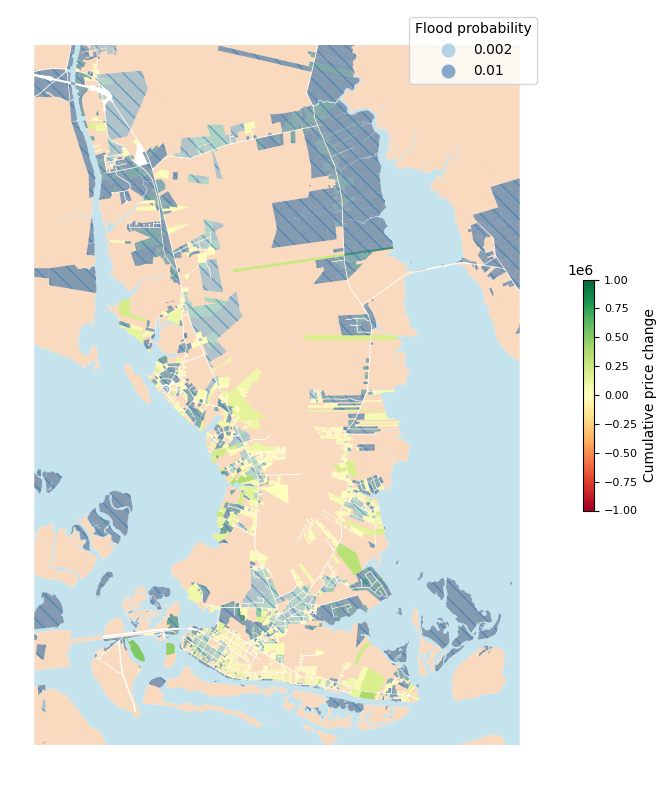

In [73]:
%matplotlib inline
plot_beaufort(variable="Cumulative price change", year=30, divergent=True)

In [ ]:
# Use this code to save figures at specified interval (used for creating GIFs/animated plots)

# %matplotlib inline
# for year in np.arange(0.5, 30, 1):
#     # NOTE: 30 years too long for plotting every year, but once in two years gives very sudden jumps.
#     plot_beaufort(variable="Cumulative price change", year=year, divergent=True, save=True)

### Household income

<IPython.core.display.Javascript object>


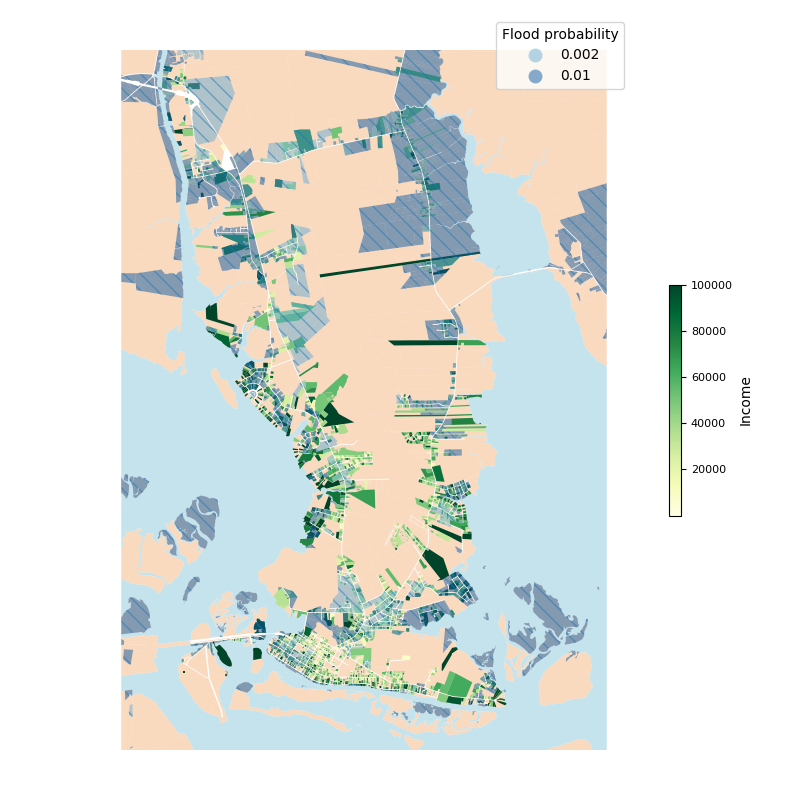

<IPython.core.display.Javascript object>


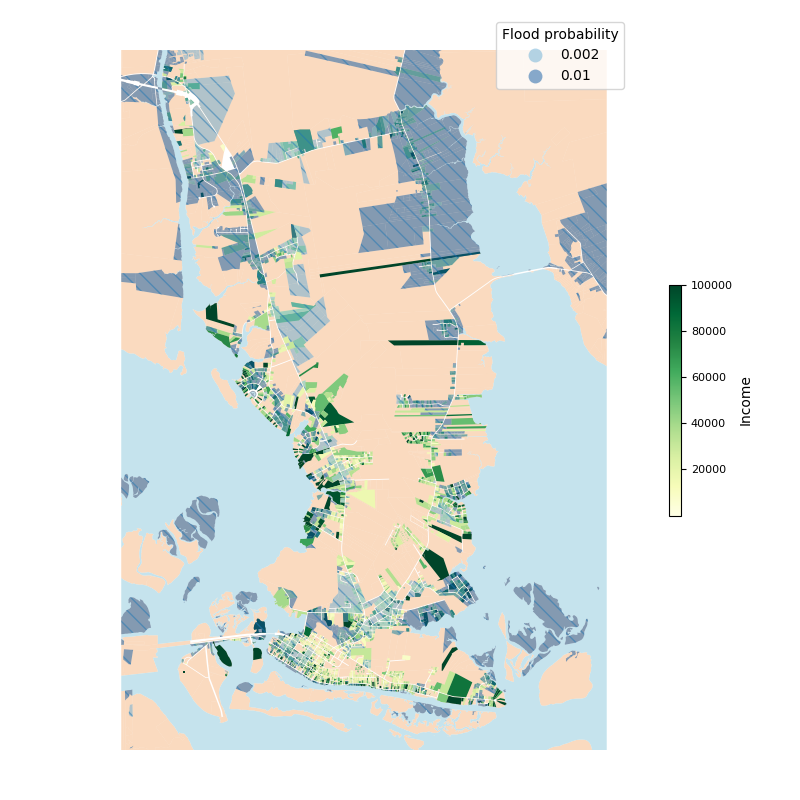

In [35]:
%matplotlib inline
plot_beaufort(variable="Income", year=1)
plot_beaufort(variable="Income", year=30)

In [39]:
# Use this code to save figures at specified interval (used for creating GIFs/animated plots)

# %matplotlib inline
# for year in np.arange(0.5, 10, 1):
#     plot_beaufort(variable="Income", year=year, logscale=False, save=True)

### Spatial distributions

#### Amenities

In [41]:
parcel_df = pd.read_csv(parcel_file_csv)
parcel_df = parcel_df.rename(columns={"ID1": "ID"}).set_index("ID")

In [44]:
spatial_df.columns
# parcel_df.columns

Index(['FID_ALL_PA', 'AREA', 'ID', 'PERIMETE_1', 'SALE_PRI_1', 'TOTAL_AC_1',
       'TOT_SQ_F_1', 'BATHROOM_1', 'DISTWTR_1', 'DISTCBD1_1', 'DISTHWY_1',
       'DISTPARK_1', 'DISTBEAC_1', 'AGE_1', 'NEWHOME_1', 'DFLOOD_X_1',
       'DFLOOD_A_1', 'FIRSTROW_1', 'POSTFIRM_1', 'OID_', 'TAX_VALUE',
       'LAND_VALUE', 'STRUC_VAL', 'OTHER_VAL', 'CITY', 'Y_BLT_HOUS',
       'BEDROOMS', 'DISTFOREST', 'DISTACCESS', 'OWNER_OCC', 'RENTER_OCC',
       'SALE_YR', 'VACANTRT', 'YR00', 'YR01', 'YR02', 'YR03', 'YR04', 'DTOWN2',
       'DTOWN9', 'SHAPE_LENG', 'SHAPE_AREA', 'geometry', 'FLOOD_PROB'],
      dtype='object')

In [50]:
# Read residential properties from shapefile
temp = spatial_df[spatial_df.index.isin(property_df.index)].copy()
# Align flood zone names between original shapefile and processed parcel characteristics file
temp = temp.rename(columns={"DFLOOD_X_1": "DFLOOD500", "DFLOOD_A_1": "DFLOOD100"})
temp["PROXAMEN"] = parcel_df["PROXAMEN"]

# Get avg. proximity coastal amenities
print("Proximity coastal amenities not in flood zone:", temp[(temp["DFLOOD500"] == 0) &
                                                             (temp["DFLOOD100"] == 0)]["PROXAMEN"].mean())
print("Proximity coastal amenities for 500 flood zone:", temp[temp["DFLOOD500"] == 1]["PROXAMEN"].mean())
print("Proximity coastal amenities for 100 flood zone:", temp[temp["DFLOOD100"] == 1]["PROXAMEN"].mean())

Proximity coastal amenities not in flood zone: 7003.512853784403
Proximity coastal amenities for 500 flood zone: 6381.742877403846
Proximity coastal amenities for 100 flood zone: 6943.780887711864


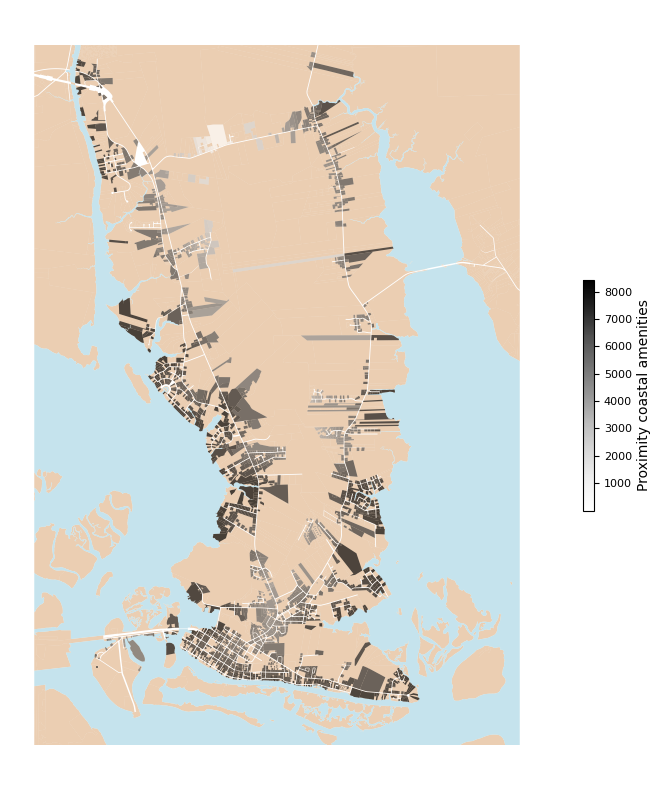

In [55]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,8))
ax.axis("off")

# Plot parcels
spatial_df[spatial_df["CITY"] != "Water"].plot(ax=ax,
                                               color="peru", alpha=0.4)
spatial_df[spatial_df["CITY"] == "Water"].plot(ax=ax,
                                               color="lightblue", alpha=0.7)

# Plot distance to coastal amenities
temp = spatial_df[spatial_df.index.isin(property_df.index)].copy()
temp["PROXAMEN"] = parcel_df["PROXAMEN"]
temp.plot("PROXAMEN", ax=ax, cmap="Greys", alpha=0.7,
          legend=True, legend_kwds={"shrink": 0.3, "label": "Proximity coastal amenities"})

# Plot settings
for ax in fig.axes:
    ax.tick_params(labelsize=8)
plt.tight_layout()
plt.show()